In [159]:
%matplotlib inline

import sys
import os

# Add parent directory (where pygestalt lives) to sys.path
sys.path.append(os.path.abspath(".."))

from pathlib import Path
import numpy as np
from skimage.filters import gabor
from matplotlib import pyplot as plt
from matplotlib.pyplot import *

import pygestalt as gs
from pygestalt import sampler

import torch
import torch.nn as nn
import torchvision

from collections import deque
from scipy.ndimage import label, center_of_mass
from scipy.ndimage import rotate

In [160]:
def make_gabor_kernels(ksize, sigma, lam, gamma=0.5, K=20, device='cpu'):
    """
    Generate K Gabor kernels with different orientations.
    Returns: tensor of shape (K, 1, ksize, ksize)
    """
    kernels = []
    angles = []
    for theta in np.linspace(0, np.pi, K, endpoint=False):  # 0 to 180 degrees
        x, y = np.meshgrid(np.arange(ksize)-ksize//2, np.arange(ksize)-ksize//2)
        x_theta = x * np.cos(theta) + y * np.sin(theta)
        y_theta = -x * np.sin(theta) + y * np.cos(theta)
        gb = np.exp(-0.5 * (x_theta**2 + (gamma*y_theta)**2)/sigma**2) * np.cos(2*np.pi*x_theta/lam)
        gb = gb - gb.mean()  # zero mean
        kernels.append(gb)
        angles.append(theta)
    kernels = np.stack(kernels)[:, None, :, :]  # (K,1,ksize,ksize)
    return torch.tensor(kernels, dtype=torch.float32, device=device), np.array(angles)

In [161]:
kernel_tensor_1, angles = make_gabor_kernels(ksize=7, sigma=2, lam=4)
kernel_tensor_2, _ = make_gabor_kernels(ksize=31, sigma=5, lam=15)

In [162]:
outdir = Path(os.getcwd()) / 'outputs'
os.makedirs(outdir, exist_ok=True)

#Ps = np.random.uniform(size=(4,2))
#Ps = np.vstack([[0.2,0], Ps, [0.8,1]])
Ps = np.array([[0.,0.], [0.1,0.9], [0.9,0.1], [1.,1.]])
#Ps = np.array([[0.,0.], [1.,1.]])

radius = 0.02
thresh = 1e-3

%time C, H = sampler.draw_positions(radius, sampler.bezier_curve(Ps), thresh=thresh)
%time D, _ = sampler.draw_positions(radius, sampler.box(), exclusions=C, thresh=thresh)

CPU times: user 3.38 s, sys: 37.2 ms, total: 3.42 s
Wall time: 3.45 s
CPU times: user 18 s, sys: 108 ms, total: 18.1 s
Wall time: 18.3 s


(512, 512)
[1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1.
 1. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1.
 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 

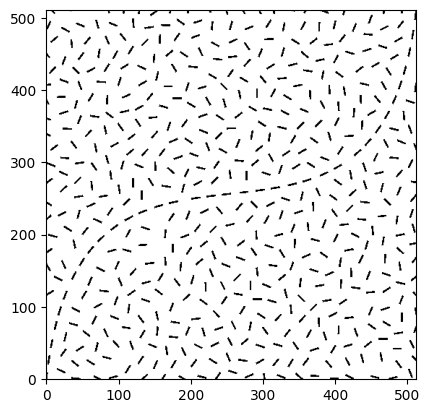

In [163]:
# Define the patch function

l=0.025
w=0.005
pfunc = lambda z,h: gs.patch.segment(z, h, l, w)

N = 512
If, Tf = gs.patch.generate_image(C, H, N=N, pfunc=pfunc)
Ig, Tg = gs.patch.generate_image(D, N=N, pfunc=pfunc)

I = If + Ig

image = torch.tensor(Ig)
image_tensor = image.unsqueeze(0).unsqueeze(0)

image_tensor = image_tensor.to(torch.float32)
kernel_tensor_1 = kernel_tensor_1.to(torch.float32)
kernel_tensor_2 = kernel_tensor_2.to(torch.float32)

plt.imshow(I, aspect='equal',origin= "lower", cmap='binary')
print(I.shape)

print(I[0])

In [164]:
conv1 = nn.functional.conv2d(image_tensor, kernel_tensor_1, stride=1, padding=3)
output = nn.functional.conv2d(conv1, kernel_tensor_2, stride=1, padding=15, groups= 20)

print(conv1.shape)
print(output.shape)

torch.Size([1, 20, 512, 512])
torch.Size([1, 20, 512, 512])


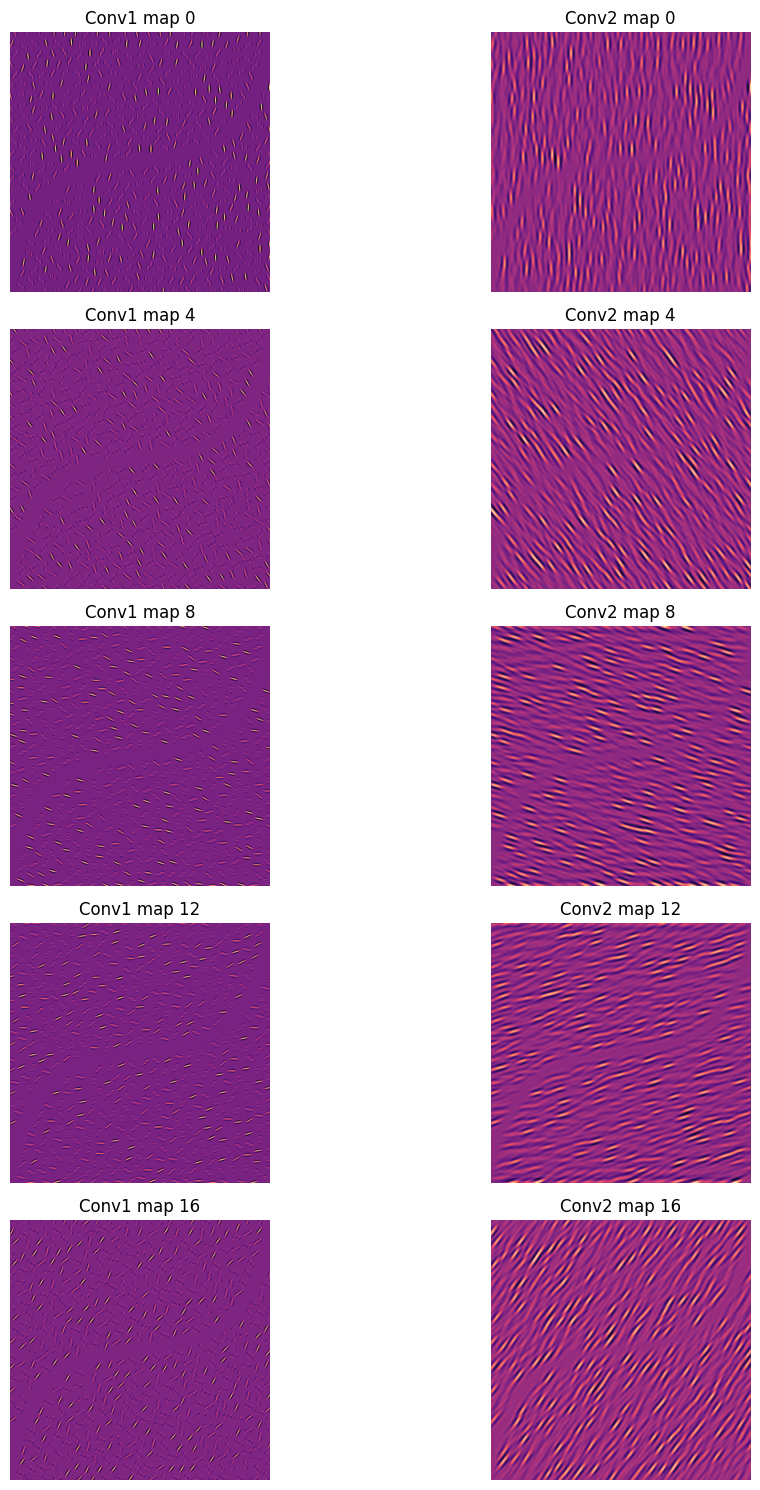

In [165]:
# Remove batch dimension: (20, H, W)
feature_maps1 = conv1.squeeze(0)
feature_maps2 = output.squeeze(0)

# Pick every 4th map
indices_to_show = list(range(0, feature_maps1.shape[0], 4))
num = len(indices_to_show)

plt.figure(figsize=(12, 3 * num))

for i, idx in enumerate(indices_to_show):
    # First convolution on the left
    plt.subplot(num, 2, 2*i + 1)
    plt.imshow(feature_maps1[idx].detach().cpu().numpy(),origin= "lower", cmap='magma')
    plt.title(f"Conv1 map {idx}")
    plt.axis('off')
    
    # Second convolution on the right
    plt.subplot(num, 2, 2*i + 2)
    plt.imshow(feature_maps2[idx].detach().cpu().numpy(), origin= "lower", cmap='magma')
    plt.title(f"Conv2 map {idx}") 
    plt.axis('off')

plt.tight_layout()
plt.show()

In [166]:
def cluster(heatmaps, threshold_ratio=0.8):
    """
    heatmaps: [1, C, H, W] tensor
    threshold_ratio: fraction of max value to consider part of a cluster
    Returns: tensor([value, channel, x, y]) of the centroid of the strongest cluster
    """
    maps = heatmaps[0].cpu().numpy()  # [C, H, W]
    C, H, W = maps.shape

    best_value = -np.inf
    best_coords = None
    best_channel = None

    for c in range(C):
        heatmap = maps[c]
        # threshold map
        thresh = heatmap > (threshold_ratio * heatmap.max())
        # label connected components
        labeled, n = label(thresh)
        if n == 0:
            continue

        # compute cluster values and find the strongest
        for cluster_id in range(1, n+1):
            mask = labeled == cluster_id
            cluster_value = heatmap[mask].sum()
            if cluster_value > best_value:
                best_value = cluster_value
                # centroid weighted by values
                cy, cx = center_of_mass(heatmap, labels=labeled, index=cluster_id)
                best_coords = (cx, cy)
                best_channel = c

    return best_value, best_channel, int(best_coords[0]), int(best_coords[1])


In [167]:
def weakest_channel(heatmaps, x, y):
    """
    heatmaps: [1, C, H, W] tensor
    x, y: pixel coordinates (integers)
    Returns: channel index (int) and value (float) of the lowest channel at that coordinate
    """
    # remove batch dimension (assume batch=1)
    maps = heatmaps[0]  # [C, H, W]

    # get values at (y, x) for all channels
    values = maps[:, y, x]  # shape: [C]

    # find channel with min value
    min_val, min_c = torch.min(values, dim=0)

    return int(min_c.item()), float(min_val.item())

In [168]:
def find_closest(image, start_x, start_y):
    """
    Finds the closest 1 in a 2D grid to the given start coordinate (x, y)
    using Euclidean distance.
    
    Args:
        grid (list of list of int) or torch.Tensor: 2D grid of 0s and 1s
        start (tuple): (x, y) coordinate to start from

    Returns:
        tuple or None: Coordinate of the closest 1 as (x, y),
                       or None if no 1 exists
    """
    # Convert grid to tensor if needed
    grid = torch.tensor(image)
    
    # Get coordinates of all 1s
    ys, xs = torch.where(grid == 1)
    
    if len(xs) == 0:  # No 1 in grid
        return None
    
    # Compute Euclidean distances in a vectorized way
    distances = torch.sqrt((xs - start_x)**2 + (ys - start_y)**2)
    
    # Find the index of the minimum distance
    min_idx = torch.argmin(distances)
    
    return int(xs[min_idx]), int(ys[min_idx])

In [169]:
def find_connected(image, start_x, start_y):
    """
    Finds all pixels with value 1 connected to the start pixel (4-connectivity).
    """
    grid = torch.tensor(image)
    rows, cols = grid.shape
    
    if grid[start_y, start_x] != 1:
        return set()  # Starting pixel is not 1

    visited = set()
    queue = deque()
    queue.append((start_x, start_y))
    visited.add((start_x, start_y))

    directions = [(-1, 0), (1, 0), (0, -1), (0, 1)]

    while queue:
        x, y = queue.popleft()
        for dx, dy in directions:
            nx, ny = x + dx, y + dy
            if 0 <= nx < cols and 0 <= ny < rows:
                if grid[ny, nx] == 1 and (nx, ny) not in visited:
                    visited.add((nx, ny))
                    queue.append((nx, ny))

    return visited

In [ ]:
def bounding_square(coords):
    """
    Finds the smallest centered square that contains all given coordinates.

    Args:
        coords (set of tuples): Set of (x, y) points.

    Returns:
        (top_left, bottom_right, side) where:
            top_left     = (x0, y0)
            bottom_right = (x1, y1)
            side         = side length of the square
    """

    if not coords:
        return None, None, 0

    # Extract coordinate arrays
    xs = [x for x, y in coords]
    ys = [y for x, y in coords]

    x_min, x_max = min(xs), max(xs)
    y_min, y_max = min(ys), max(ys)

    # Original bounding box dimensions
    width = x_max - x_min
    height = y_max - y_min

    # Square side is the larger dimension
    side = max(width, height)

    # Center of the rectangle
    cx = (x_min + x_max) / 2
    cy = (y_min + y_max) / 2

    # Top-left and bottom-right of the centered square
    half = side / 2

    x0 = cx - half
    y0 = cy - half
    x1 = cx + half
    y1 = cy + half

    # Round to ints if desired
    # (comment these out if you want float coordinates)
    x0 = int(x0)
    y0 = int(y0)
    x1 = int(x1)
    y1 = int(y1)
    side = int(side)

    return [(x0-1, y0-1), (x1+1, y1), side]

In [171]:
val, channel, x, y = cluster(output)
weak_channel, lowest_val = weakest_channel(output, x, y)
close_x, close_y = find_closest(Ig, x, y)
line = find_connected(Ig, close_x, close_y)
outline = bounding_square(line)

print(outline)
print(channel)
print(weak_channel)

[(349, 78), (359, 88), 10]
15
12


In [172]:
def rotate_img(img, angle_rad):
    """
    Rotates a binary (0/1) image by angle_degrees.
    Output remains float; convert back to 0/1 if needed.
    """

    angle_degrees = np.rad2deg(angle_rad)
    rotated = rotate(
        img.astype(float),
        angle = angle_degrees,
        reshape=False,        # keep same size
        order=1,              # bilinear interpolation
        mode='constant',
        cval=0.0
    )
    
    # Optional: threshold to restore strict 0/1 pattern
    return (rotated > 0.5).astype(np.uint8)

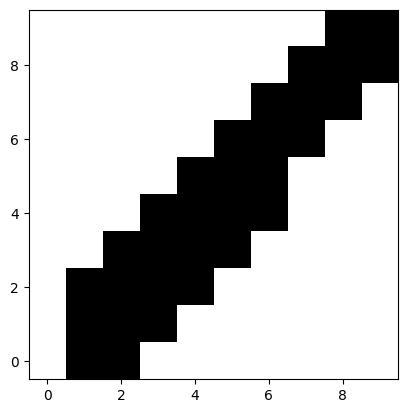

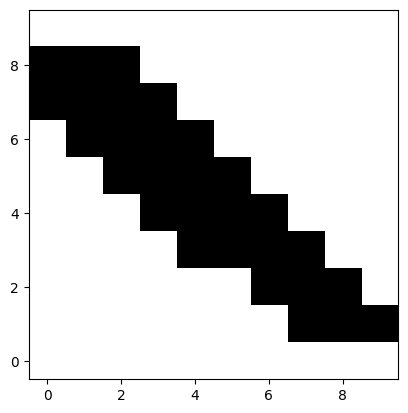

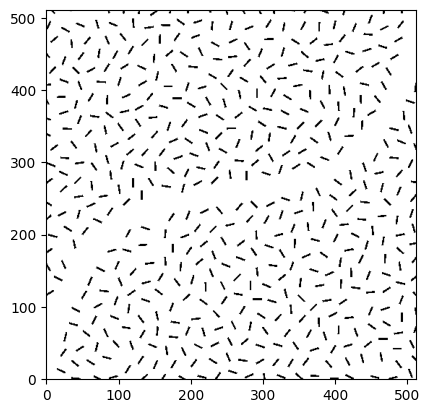

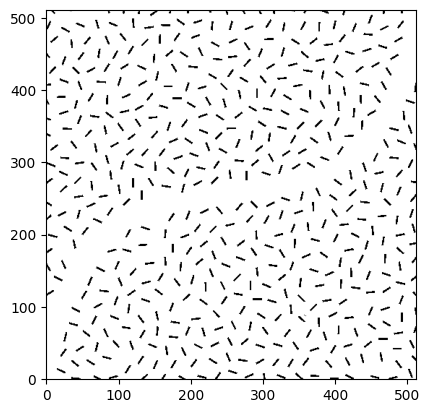

In [173]:
import numpy as np
from scipy.ndimage import rotate
import matplotlib.pyplot as plt

newIg = Ig.copy()

x0, y0 = outline[0]
x1, y1 = outline[1]
sub = Ig[y0:y1, x0:x1].copy()

plt.imshow(sub, aspect='equal', origin='lower', cmap='binary')
plt.show()

# Rotate patch and keep same size
new = rotate_img(sub,1.5)

plt.imshow(new, aspect='equal', origin='lower', cmap='binary')
plt.show()

newIg[y0:y1, x0:x1] = new

plt.imshow(Ig, aspect='equal', origin='lower', cmap='binary')
plt.show()

plt.imshow(newIg, aspect='equal', origin='lower', cmap='binary')
plt.show()
